# Art Generation

Using Neural Style Transfer for generating art.

_PyTorch implementation of the assignment of Course 4 of Coursera's Deep Learning Specialization_.

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils

from PIL import Image

## Reproducibility

In [2]:
seed = 24
random.seed(seed)
torch.manual_seed(seed);

## Device Configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Model

Neural Style Transfer uses **transfer learning** by using a pre-trained Convolutional Neural Network to extract features of the content and style images. Following the implementation of the original [paper](https://arxiv.org/abs/1508.06576), we will use a VGG-19 model. We will also replace the `MaxPool` layers with `AvgPool`  layers since the authors found it leads to better results.

In [4]:
# Load the pretrained model
model = models.vgg19(pretrained=True)

# Replace MaxPool with AvgPool layers
for i, child in model.features.named_children():
    if isinstance(child, nn.MaxPool2d):
        model.features[int(i)] = nn.AvgPool2d(kernel_size=2, stride=2)

# Set it to eval mode as we're not training it
model.eval();

# Also freeze all weights since we won't be tuning them
for param in model.parameters():
    param.requires_grad = False

model = model.to(device)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPool

## Optimization

We'll use Adam for optimizing the **pixel values** of a noise generated input image to match **content** and **style** images.

### Content Loss

To ensure that the generated image $G$ matches the content of the _content_ image $C$, we use the following loss function:

$$L_{content} = \frac{1}{4 \cdot c \cdot h \cdot w} \cdot \sum (a^C - a^G)^2$$

where

- $c$: number of channels
- $h$: height of the images
- $w$: width of the images
- $a^C$: activations of some layer _L_ from the pretrained network for the image $C$
- $a^G$: activations of some layer _L_ from the pretrained network for the image $G$

_Note: In practice, we'll get the most visually pleasing results if we choose a layer in the middle of the network; neither too shallow nor too deep._

### Style Loss

To ensure that the generated image $G$ matches the style of the _style_ image $S$, we define the following loss function:

$$L_{style} = \sum_l^L \lambda_l \cdot L_{style}^l(a_l^S,a_l^G)$$

This is done for $L$ layers from the pretrained network, where

- $l$: is the current layer we're evaluating
- $\lambda_l: is the weight to give to the loss of the current layer$
- $L_{style}^l(a^S,a^G)$: is the style loss using layer $l$ with activations for $S$ and $G$ from that layer

The style loss for a particular layer $l$ is computed as follows:

$$L_{style}^l(a_l^S,a_l^G) = \frac{1}{4 \cdot c^2 \cdot (h \cdot w)^2} \sum (G_M^{a_l^S} - G_M^{a_l^G})^2$$

where

- $c$: number of channels
- $h$: height of the images
- $w$: width of the images
- $G_M^{a_l^S}$: Gram matrix of the activations of layer $l$ for image $S$
- $G_M^{a_l^G}$: Gram matrix of the activations of layer $l$ for image $G$

The Gram matrix computes the **correlation** between filters (i.e. channels) as follows:

$$G^I = I^TI$$

where the denominators acts as a normalizer.

To compute this matrix the input $I$ needs to be reshaped into the form $c$ x ($h \cdot w$).

_Note: The higher the value of the dot product, the more correlated the filters are._

### Total Loss

We can now define the total optimization loss of the generated image $G$ by combining the **content** and **style** losses:

$$L(G) = \alpha L_{content}(C,G) + \beta L_{style}(S,G)$$

where $\alpha$ and $\beta$ are hyperparameters that determine the weight of the content and style, respectively, when blending them into the total cost.

In [5]:
# Define some transforms to match the requirements of VGG-19
# See: https://pytorch.org/docs/stable/torchvision/models.html
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [6]:
# Load the content and style images
content_image = Image.open('img/content.jpg').convert('RGB')
style_image = Image.open('img/style.jpg').convert('RGB')

content_image = TF.resize(content_image, (224, 224))
style_image = TF.resize(style_image, (224, 224))

In [7]:
# Generate a noisy image derived from the content image so that the content matches more quickly as in the Deep Learning Specialization assignment
noise_image = np.random.uniform(0, 255, (224, 224, 3)).astype(np.uint8)
noise_ratio = 0.6

# Set the input_image to be a weighted average of the content_image and a noise_image
input_image = noise_image * noise_ratio + np.array(content_image) * (1. - noise_ratio)
# Clip the values between 0 and 255
input_image = np.clip(input_image, 0, 255)

content_image = transform(content_image)
style_image = transform(style_image)
# Convert the image as uint8 as required by PyTorch's transforms
# See: https://pytorch.org/docs/stable/torchvision/transforms.html#conversion-transforms
input_image = transform(input_image.astype(np.uint8))

In [8]:
# Expand the dimension of the images to add the fake the "batch size"
content_image = content_image.unsqueeze(0)
style_image = style_image.unsqueeze(0)
input_image = input_image.unsqueeze(0)

# Move all images to our device
content_image = content_image.to(device)
style_image = style_image.to(device)
input_image = input_image.to(device)

Let's look at our content, style and randomly generate input images, in that order.

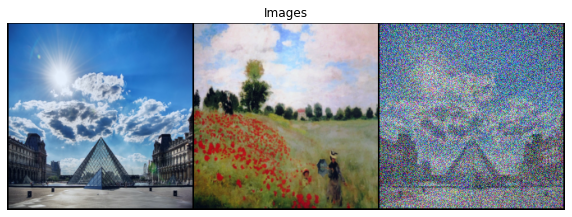

In [9]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Images')

# We need to move the images to the CPU so that they can be plotted
# We also squeeze back the fake batch size dimension
content = content_image.cpu().squeeze(0)
style = style_image.cpu().squeeze(0)
generated = input_image.cpu().squeeze(0)

# We need to swap the axes to (height, width, channels) for matplotlib to plot the image correctly
plt.imshow(np.transpose(vutils.make_grid([content, style, generated], padding=2, normalize=True, scale_each=True), (1, 2, 0)));

We now define the content loss.

In [10]:
def content_loss(a_c, a_g):
    _, c, h, w = a_c.shape
    return torch.sum(torch.pow(a_c - a_g, 2)).div(4. * c * h * w)

And the style loss.

In [11]:
def gram(x):
    # `torch.mm()` stands for matrix multiply (i.e. dot product) and `t()` stands for transpose
    # Reshape input into c x (h * w)
    _, c, h, w = x.shape
    reshaped = x.reshape((c, h * w))

    return torch.mm(reshaped, reshaped.t())

def style_loss_layer(a_s, a_g):
    _, c, h, w = a_s.shape
    return torch.sum(torch.pow(gram(a_s) - gram(a_g), 2)).div(4. * c ** 2 * (h * w) ** 2)

def style_loss(activations_s, activations_g):
    assert len(activations_s) == len(activations_g)
    loss = 0.

    for i in range(len(activations_s)):
        layer_loss = style_loss_layer(activations_s[i], activations_g[i])
        # Use 0.2 for the weights as in the Deep Learning Specialization assignment
        loss += 0.2 * layer_loss

    return loss

And finally we define the total loss.

In [12]:
def total_loss(c_loss, s_loss, alpha, beta):
    return alpha * c_loss + beta * s_loss

Lastly, we set up our optimizer. For Neural Style Transfer, we want to optimize the **pixel values** of the generated image directly!

In [13]:
# We need to pass the input image as a list since the optimization algorithms requires a list of tensors as input
# We explicitly mark the image as requiring gradients so that PyTorch includes it in the computational graph for backprop (i.e. become optimizable)
# In contrast with the Deep Learning Specialization assignment, we use the default learning rate (0.001) from Adam
optimizer = optim.Adam([input_image.requires_grad_()])

## Training

Time to "train" and transfer the style to our generated image!

In [14]:
# Training configuration
# In contrast with the Deep Learning Specialization assignment, we use way more epochs since we're usint a much smaller learning rate
epochs = 10000

In [15]:
# Register hooks to access the activations of the hidden layers of the model
# See: https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/4
activations = {}
def get_activations(name):
    def hook(module, input, output):
        activations[name] = output
    return hook

# For the content cost we use layer conv4_2 as in the Deep Learning Specialization assignment
# The layer number was obtained by counting using the print output of the model in previous sections
model.features[21].register_forward_hook(get_activations('conv4_2'))

# For the style cost we use the same layers as in the Deep Learning Specialization assignment
# conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
model.features[0].register_forward_hook(get_activations('conv1_1'));
model.features[5].register_forward_hook(get_activations('conv2_1'));
model.features[10].register_forward_hook(get_activations('conv3_1'));
model.features[19].register_forward_hook(get_activations('conv4_1'));
model.features[28].register_forward_hook(get_activations('conv5_1'));

# Helper methods for retrieving the content and style activations
def get_content_activations(detach):
    return activations['conv4_2'].detach() if detach else activations['conv4_2']

def get_style_activations(detach):
    return [(value.detach() if detach else value) for key, value in activations.items() if key != 'conv4_2']

[0/10000]	Content Loss: 0.13475194573402405	Style Loss: 0.067969411611557	Loss: 681.0416259765625
[1000/10000]	Content Loss: 0.1639021635055542	Style Loss: 0.005222276318818331	Loss: 53.861785888671875
[2000/10000]	Content Loss: 0.16592766344547272	Style Loss: 0.001815391588024795	Loss: 19.81319236755371
[3000/10000]	Content Loss: 0.16113750636577606	Style Loss: 0.0010074962629005313	Loss: 11.6863374710083
[4000/10000]	Content Loss: 0.15543565154075623	Style Loss: 0.0006306685972958803	Loss: 7.861042499542236
[5000/10000]	Content Loss: 0.14901739358901978	Style Loss: 0.0004237938846927136	Loss: 5.728112697601318
[6000/10000]	Content Loss: 0.14295218884944916	Style Loss: 0.00030738330679014325	Loss: 4.503355026245117
[7000/10000]	Content Loss: 0.13769815862178802	Style Loss: 0.0002414728223811835	Loss: 3.7917098999023438
[8000/10000]	Content Loss: 0.13371454179286957	Style Loss: 0.00019996633636765182	Loss: 3.336808681488037
[9000/10000]	Content Loss: 0.13037557899951935	Style Loss: 0.0

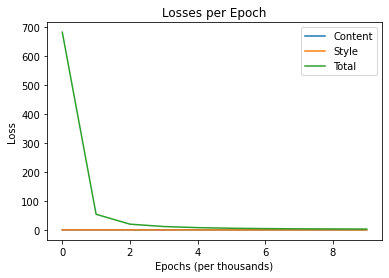

In [16]:
# Main training loop
content_losses = []
style_losses = []
losses = []

# Cache the activations for the content image and the style image
# We detach the activations from the computational graph since we don't want gradients to flow through them
# because we're not optimizing the content or style images!
model(content_image)
a_c = get_content_activations(detach=True)

model(style_image)
activations_s = get_style_activations(detach=True)

for epoch in range(epochs):
    optimizer.zero_grad()

    model(input_image)

    # Compute the content loss
    # We don't detach from the computational graph because we do want gradients to flow to be able to backprop through to the input image
    a_g = get_content_activations(detach=False)
    c_loss = content_loss(a_c, a_g)

    # Compute the style loss
    # We also don't detach these activations from the computational graph
    activations_g = get_style_activations(detach=False)
    s_loss = style_loss(activations_s, activations_g)
    
    # Compute the total loss
    # In contrast with the Deep Learning Specialization assignment, we give much more weight to the style
    # This results in a better transfer of the style probably due to the lower learning rate
    loss = total_loss(c_loss, s_loss, alpha=10, beta=10000)

    # Optimize to improve the generated imagemean
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        # Detach the loss to avoid saving any more computations on it
        content_losses.append(c_loss.detach().cpu().numpy())
        style_losses.append(s_loss.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())
        print(f'[{epoch}/{epochs}]\tContent Loss: {c_loss}\tStyle Loss: {s_loss}\tLoss: {loss}')

# Plot the losses
plt.plot(np.squeeze(content_losses), label='Content')
plt.plot(np.squeeze(style_losses), label='Style')
plt.plot(np.squeeze(losses), label='Total')
plt.ylabel('Loss')
plt.xlabel('Epochs (per thousands)')
plt.title('Losses per Epoch')
plt.legend()
plt.show()

## Testing

Now that we have trained, we can evaluate by looking at the generated image. The image should match our content image but with the style of the style image. 

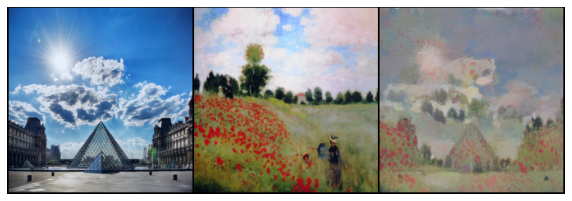

In [17]:
plt.figure(figsize=(10, 10))
plt.axis('off')

# We need to move the image to the CPU so that it can be plotted
# We also squeeze back the fake batch size dimension
content = content_image.cpu().squeeze(0)
style = style_image.cpu().squeeze(0)
# Since the input image was marked as optimizable (requires gradients), we also need to detach it
generated = input_image.detach().cpu().squeeze(0)

# We need to swap the axes to (height, width, channels) for matplotlib to plot the image correctly
# plt.imshow(np.transpose(generated, (1, 2, 0)));
plt.imshow(np.transpose(vutils.make_grid([content, style, generated], padding=2, normalize=True, scale_each=True), (1, 2, 0)));